In [2]:
import gym
import matplotlib.pyplot as plt
import collections
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from tensorflow import keras
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.python.client import device_lib
from random import sample

from hyperopt import fmin, tpe, hp, Trials, space_eval, STATUS_OK
import pickle

import pandas as pd
from openpyxl import load_workbook

import xgboost as xgb
import shap

print(tf.__version__)
print(device_lib.list_local_devices())

c:\Users\Go\miniconda3\envs\tensorgpu\lib\site-packages\flatbuffers\compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
c:\Users\Go\miniconda3\envs\tensorgpu\lib\site-packages\keras_preprocessing\image\utils.py:23: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
c:\Users\Go\miniconda3\envs\tensorgpu\lib\site-packages\keras_preprocessing\image\utils.py:24: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
c:\Users\Go\miniconda3\envs\tensorgpu\lib\site-packages\keras_preprocessing\image\utils.py:25: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.BICUBIC,
c:\Users\Go\minic

2.8.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3093295315815818638
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3667263488
locality {
  bus_id: 1
  links {
  }
}
incarnation: 285263834904563014
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [25]:
def get_action(xgbmodel, state, eps, is_greedy):
    input = xgb.DMatrix(state.reshape([-1,4]))
    if is_greedy:
        if xgbmodel.predict(input) > 0.5:
            a = 1
        else:
            a = 0
        return a
    else:
        if np.random.choice([True, False],p = [eps,1-eps]):
            a = np.random.choice(2,p = [0.5,0.5])
        else:
            if xgbmodel.predict(input) > 0.5:
                a = 1
            else:
                a = 0
        return a


def make_model(states, actions, model_name):
    x = np.concatenate(states, axis = 0).reshape([-1,4])
    y = np.array(actions).reshape([-1,1])
    dtrain = xgb.DMatrix(x, y)
    if model_name == None:
        model = xgb.train(params, dtrain)
    else:
        model = xgb.train(params, dtrain, xgb_model=model_name)
    return model




In [26]:
%%time
params = {
    "tree_method": "hist", 
          "objective": 'binary:logistic',
        # "objective": 'multi:softprob',
        
          "subsample": 0.8,
          "colsample_bytree": 0.8,
          "single_precision_histogram" : True,
          }

env = gym.make('CartPole-v1')

xgb_clf = make_model([[0,0,0,0]],[[1]], model_name=None)
xgb_clf.save_model("model.json")
cumr_history = []
epsilon = 1
eps_min = 0.1
avg = 8

for _ in range(100):  # 배치학습
    if _%50 == 0:
        print(f"episode: {_}")
        print(f"최근 10 에피소드 평균점수: {avg}")
    total_r_list = []
    states_list = []
    actions_list = []
    

    for _ in range(10):
        if epsilon > eps_min:
            epsilon = epsilon*0.99
        else:
            epsilon = eps_min
        states = []
        actions = []
        total_r = 0
        s = env.reset()
        a = get_action(xgb_clf,s,epsilon, is_greedy=False)

        states.append(s)
        actions.append(a)
        while True:
            ns, r, done, _ = env.step(a)
            total_r += r
            done = 1 if done else 0


            if done == 1:
                s = env.reset()
                # env.render()
                a = get_action(xgb_clf,s,epsilon, is_greedy=False)
                states.append(s)
                actions.append(a)
                total_r_list.append(total_r)
                states_list.append(states)
                actions_list.append(actions)
                cumr_history.append(total_r)
                break
            else:
                s = ns
                a = get_action(xgb_clf,s,epsilon, is_greedy=False)
                states.append(s)
                actions.append(a)

    

    
    avg = sum(total_r_list)/len(total_r_list)
    print(avg)
    # print(f"최근 10 에피소드 평균점수: {avg}") if avg < 250 else print(f"최근 10 에피소드 평균점수: {avg} --학습완료--")
    if avg > 250:
        print(f"최근 10 에피소드 평균점수: {avg} --학습완료--")
        break
    train_x = []
    train_y = []

    for i in range(len(total_r_list)):
        if total_r_list[i] > avg:

            train_x.extend(states_list[i])
            train_y.extend(actions_list[i])

    
    xgb_clf = make_model(train_x,train_y,"model.json")

episode: 0
최근 10 에피소드 평균점수: 8
21.5
21.3
18.7
22.2
32.5
30.9
51.0
31.6
39.4
48.4
49.2
48.5
81.9
90.1
129.9
153.5
164.7
143.8
135.3
133.3
153.3
194.6
136.5
165.3
250.9
최근 10 에피소드 평균점수: 250.9 --학습완료--
CPU times: total: 5min 13s
Wall time: 25.1 s


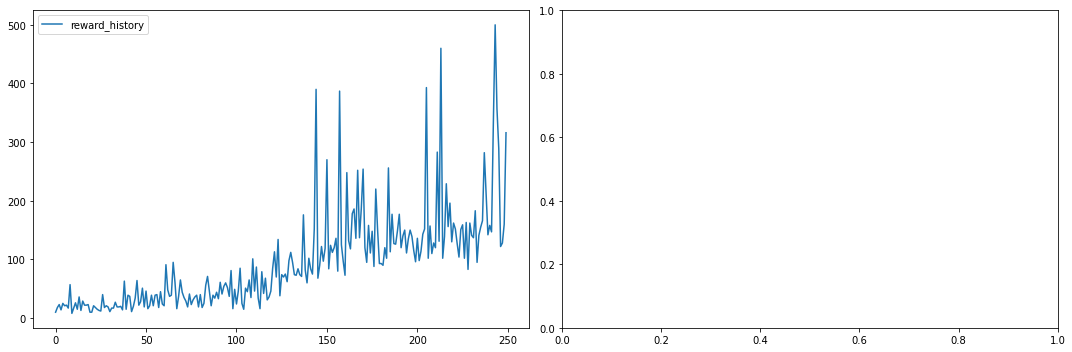

In [27]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(cumr_history, label='reward_history')
axes[0].legend()
# axes[1].plot(critic_loss_list, label='critic loss')
# axes[1].legend()
# axes[2].plot(cur_list, label='cumulated reward history')
# axes[2].legend()
# axes[2].hist(cur_list, density=True, label='only_online_awac')
# axes[2].legend()
fig.tight_layout()

* test

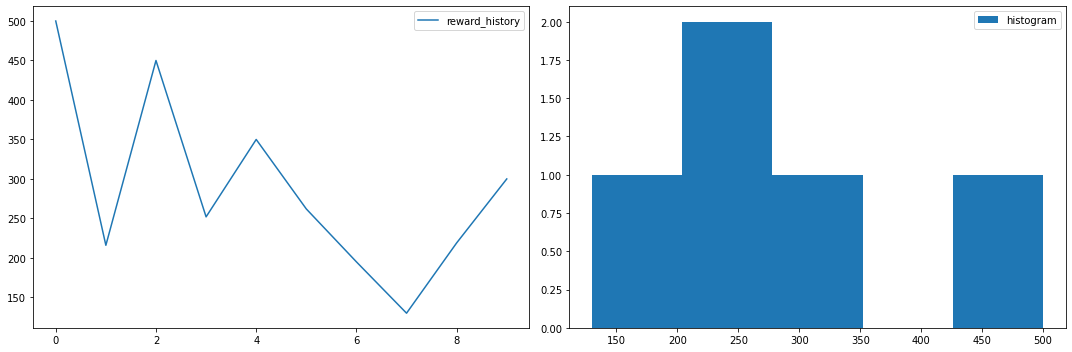

In [28]:
rewards = []
env = gym.make('CartPole-v1')

for _ in range(10):
    total_r = 0
    s = env.reset()
    # env.render()
    a = get_action(xgb_clf,s,epsilon, is_greedy=True)
    while True:
        ns, r, done, _ = env.step(a)
        # env.render()
        total_r += r
        done = 1 if done else 0


        if done == 1:
            s = env.reset()
            # env.render()
            a = get_action(xgb_clf,s,epsilon, is_greedy=True)
            rewards.append(total_r)
          
            break
        else:
            s = ns
            a = get_action(xgb_clf,s,epsilon, is_greedy=True)

fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(rewards, label='reward_history')
axes[0].legend()
axes[1].hist(rewards, label='histogram')
axes[1].legend()
# axes[2].plot(cur_list, label='cumulated reward history')
# axes[2].legend()
# axes[2].hist(cur_list, density=True, label='only_online_awac')
# axes[2].legend()
fig.tight_layout()
            

** shap 분석

In [30]:
explainer = shap.TreeExplainer(xgb_clf)
x = np.concatenate(train_x, axis = 0).reshape([-1,4])
shap_values = explainer.shap_values(x)

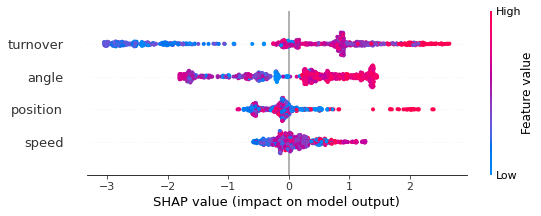

In [35]:
feat_space = ['position', 'speed', 'angle', 'turnover']
shap.summary_plot(shap_values, x, feature_names=feat_space,show=True,max_display=4)

In [36]:
import scipy
from scipy.spatial.distance import pdist

In [38]:
import matplotlib.pylab as pl

In [39]:
def hclust_order(X, metric="sqeuclidean"):
    """ A leaf ordering is under-defined, this picks the ordering that keeps nearby samples similar.
    """
    
    # compute a hierarchical clustering
    D = scipy.spatial.distance.pdist(X, metric)
    cluster_matrix = scipy.cluster.hierarchy.complete(D)
    
    # merge clusters, rotating them to make the end points match as best we can
    sets = [[i] for i in range(X.shape[0])]
    for i in range(cluster_matrix.shape[0]):
        s1 = sets[int(cluster_matrix[i,0])]
        s2 = sets[int(cluster_matrix[i,1])]
        
        # compute distances between the end points of the lists
        d_s1_s2 = pdist(np.vstack([X[s1[-1],:], X[s2[0],:]]), metric)[0]
        d_s2_s1 = pdist(np.vstack([X[s1[0],:], X[s2[-1],:]]), metric)[0]
        d_s1r_s2 = pdist(np.vstack([X[s1[0],:], X[s2[0],:]]), metric)[0]
        d_s1_s2r = pdist(np.vstack([X[s1[-1],:], X[s2[-1],:]]), metric)[0]

        # concatenete the lists in the way the minimizes the difference between
        # the samples at the junction
        best = min(d_s1_s2, d_s2_s1, d_s1r_s2, d_s1_s2r)
        if best == d_s1_s2:
            sets.append(s1 + s2)
        elif best == d_s2_s1:
            sets.append(s2 + s1)
        elif best == d_s1r_s2:
            sets.append(list(reversed(s1)) + s2)
        else:
            sets.append(s1 + list(reversed(s2)))
    
    return sets[-1]

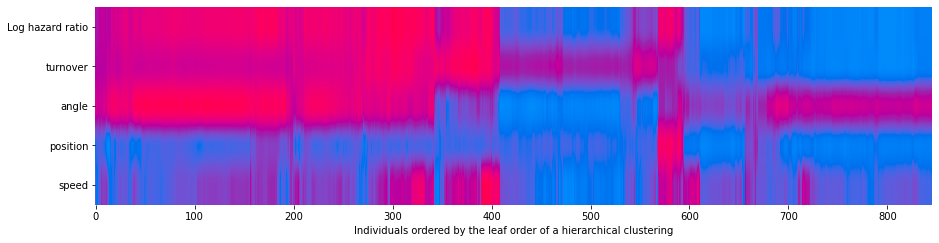

In [62]:
clustOrder = hclust_order(shap_values)

col_inds = np.argsort(-np.abs(shap_values).mean(0))[:]

col_list = []
for i in col_inds:
  col_list = col_list + [feat_space[i]]




shap_normed = shap_values.copy()
for i in col_inds:
    shap_normed[:,i] -= shap_normed[:,i].min()
    shap_normed[:,i] /= shap_normed[:,i].max()
    
f = pl.figure(figsize=(15,20))
total = shap_values[clustOrder,:].sum(1)
total -= total.min()
total /= total.max()
pl.imshow(np.vstack([total, shap_normed[clustOrder,:][:,col_inds].T]), aspect=40, cmap=shap.plots.colors.red_blue)
pl.yticks(np.arange(len(col_inds)+1))
pl.gca().set_yticklabels(["Log hazard ratio"] + col_list)
pl.gca().spines['right'].set_visible(False)
pl.gca().spines['left'].set_visible(False)
pl.gca().spines['top'].set_visible(False)
pl.gca().spines['bottom'].set_visible(False)
pl.xlabel("Individuals ordered by the leaf order of a hierarchical clustering")
#pl.savefig("raw_figures/nhanes_heatmap.pdf", dpi=400)
pl.show()

In [64]:
shap_interaction_values = explainer.shap_interaction_values(x)

In [66]:
shap_interaction_values[0]

array([[-0.24191654,  0.02524768, -0.0024823 ,  0.09126378],
       [ 0.02524769, -0.07298533, -0.15745163, -0.00712224],
       [-0.00248233, -0.1574516 , -0.9499848 , -0.483943  ],
       [ 0.09126374, -0.00712224, -0.483943  ,  0.30754632]],
      dtype=float32)

In [68]:
input = xgb.DMatrix(x.reshape([-1,4]))
pred = xgb_clf.predict(input)

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


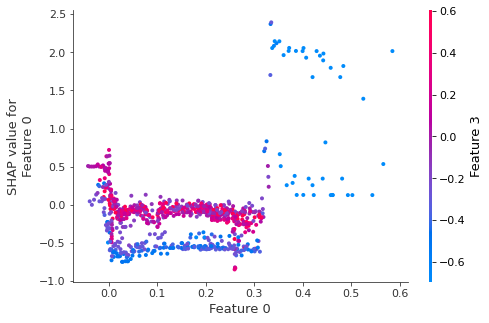

In [74]:
shap.dependence_plot(0, shap_values, x)

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


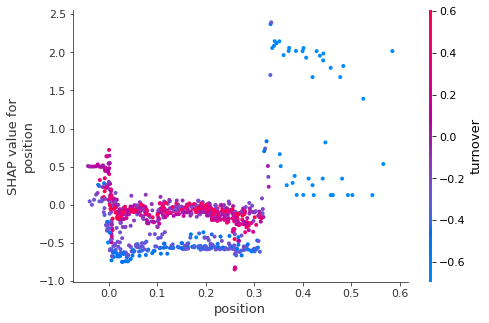

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


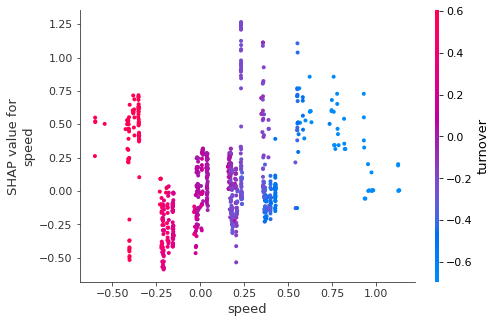

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


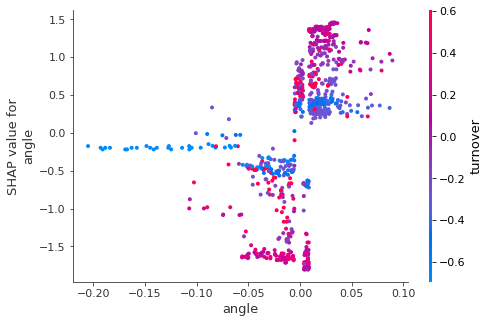

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


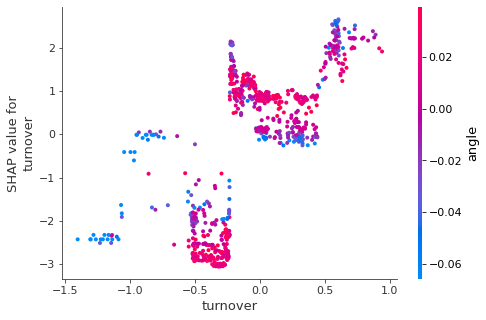

In [85]:
for name in range(len(feat_space)):
    shap.dependence_plot(name, shap_values, x, feat_space)